In [49]:
%matplotlib inline
%load_ext autoreload
%autoreload 5
%autosave 15

from time import time
from math 

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.cross_validation import cross_val_score, train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 15 seconds


In [36]:
# load data
data = pd.read_csv('data.csv')
total_actions = dict(data.action_type.value_counts())
# TODO: tune this parameter
threshold = 100
# TODO: check if it's needed
data['type'] = data.apply(lambda row: row['action_type'] if total_actions[row['action_type']] >= threshold \
                          else row['combined_shot_type'], axis=1)
data['time_remaining'] = data.apply(lambda row: row['minutes_remaining'] * 60 + row['seconds_remaining'], axis=1)

# TODO: tune this parameter
threshold = 3
# TODO: find out why he cant hit @ 14 secs to go
anomaly = 14
data['last_moment'] = data.apply(lambda row: row['time_remaining'] < threshold or row['time_remaining'] == anomaly, axis=1)
data['away'] = data.matchup.str.contains('@')
data['season'] = data.apply(lambda row: int(row['season'].split('-')[0]), axis=1)
data['month'] = data.apply(lambda row: int(row['game_date'].split('-')[1]), axis=1)

# remove outliers
data['shot_distance'] = data.apply(lambda row: 28 if row['shot_distance'] > 28 else row['shot_distance'], axis=1)

features = [
    'time_remaining',
    'shot_distance',
    'last_moment',
    'away',
]
binarize = [
    'type',
    'period',
    'shot_zone_area',
    'shot_zone_basic',
    'shot_zone_range',
    'opponent',
    'season',
    'shot_type',
    'action_type',
    'combined_shot_type'
]  
dummie_counter = {}
for feature in binarize:
    dummie_counter[feature] = len(data[feature].unique())
    
data = pd.concat([data[binarize], pd.get_dummies(data, columns=binarize)], axis=1)
for col in data.columns.tolist():
    for feature in binarize:
        if col.startswith(feature) and col != feature:
            features.append(col)
data.head()

,type,period,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,season,shot_type,action_type,combined_shot_type,...,action_type_Turnaround Fadeaway shot,action_type_Turnaround Finger Roll Shot,action_type_Turnaround Hook Shot,action_type_Turnaround Jump Shot,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot
0,Jump Shot,1,Right Side(R),Mid-Range,16-24 ft.,POR,2000,2PT Field Goal,Jump Shot,Jump Shot,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Jump Shot,1,Left Side(L),Mid-Range,8-16 ft.,POR,2000,2PT Field Goal,Jump Shot,Jump Shot,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Jump Shot,1,Left Side Center(LC),Mid-Range,16-24 ft.,POR,2000,2PT Field Goal,Jump Shot,Jump Shot,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Jump Shot,1,Right Side Center(RC),Mid-Range,16-24 ft.,POR,2000,2PT Field Goal,Jump Shot,Jump Shot,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Driving Dunk Shot,2,Center(C),Restricted Area,Less Than 8 ft.,POR,2000,2PT Field Goal,Driving Dunk Shot,Dunk,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


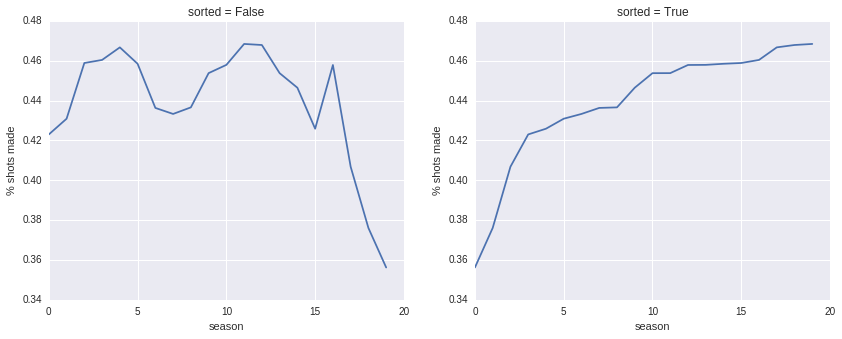

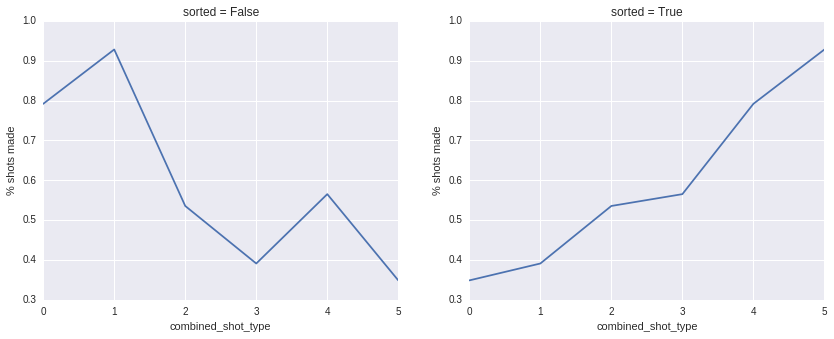

In [29]:
def get_acc(data, field):
    ct = pd.crosstab(data.shot_made_flag, data[field]).apply(lambda x: x / x.sum(), axis=0)
    x, y = ct.columns, ct.values[1, :]
    plt.figure(figsize=(7, 5))
    plt.plot(x, y)
    plt.xlabel(field)
    plt.ylabel('% shots made')
    plt.show()
    
def plot_accuracy(data, field, sort=False):
    ct = pd.crosstab(data.shot_made_flag, data[field]).apply(lambda x: x / x.sum(), axis=0)
    temp = list(zip(ct.values[1, :], ct.columns))
    if sort:
        temp.sort()
    new_map = {}
    for index, (acc, old_number) in enumerate(temp):
        new_map[old_number] = index
    ct = pd.crosstab(data.shot_made_flag, data[field].map(new_map)).apply(lambda x: x / x.sum(), axis=0)
    x, y = ct.columns, ct.values[1, :]
    plt.plot(x, y)
    plt.title('sorted = ' + str(sort))
    plt.xlabel(field)
    plt.ylabel('% shots made')

def plot(data, field):
    plt.figure(figsize=(14, 5))
    plt.subplot(121)
    plot_accuracy(data, field, sort=False)
    plt.subplot(122)
    plot_accuracy(data, field, sort=True)
    plt.show()
plot(data, 'season')
plot(data, 'combined_shot_type')

In [37]:
# split into train and test
train = data[~data['shot_made_flag'].isnull()]
test = data[data['shot_made_flag'].isnull()]
print('train size: ' + str(len(train)))
print('test size:  ' + str(len(test)))

train size: 25697
test size:  5000


In [105]:
features = [
    'shot_distance',
    'last_moment',
    'away',
    'loc_x',
    'loc_y'
]
binarize = [
    'type',
    'period',
    'shot_zone_area',
    'shot_zone_basic',
    'shot_zone_range',
    'opponent',
    'season',
    'action_type',
    'combined_shot_type',
]
for col in data.columns.tolist():
    for feature in binarize:
        if col.startswith(feature) and col != feature:
            features.append(col)
            
# prepare data for estimators
target = 'shot_made_flag'
X_test = test[features]
X_train = train[features]
y_train = train[target]
print(X_train.shape)
print(y_train.shape)

(25697, 167)
(25697,)


In [31]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds, metrics=['logloss'], show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    # Test params
    X_train, X_valid, y_train, y_valid = train_test_split(dtrain[predictors], dtrain[target], test_size=0.2)
    alg.fit(X_train, y_train, eval_metric='logloss')
    y_pred = alg.predict_proba(X_valid)[:,1]
    
    result = log_loss(y_valid, y_pred)
    print(result)
    return result

In [88]:
params = {
    'base_score': 0.5, 
    'colsample_bylevel': 1,
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 1,
    'n_estimators': 600,
    'nthread': -1,
    'objective': 'binary:logistic',
    'seed': 27,
    'silent': True,
    'subsample': 0.8
}
clf = xgb.XGBClassifier()

In [69]:
get_default_score()

0.605483833647 : from 0.604224779713 to 0.606263764098


0.60548383364743819

In [97]:
features_to_test = [
    'time_remaining',
    'shot_distance',
    'last_moment',
    'away',
    'loc_x',
    'loc_y'
]
binarize_to_test = [
    'type',
    'period',
    'shot_zone_area',
    'shot_zone_basic',
    'shot_zone_range',
    'opponent',
    'season',
    'shot_type',
    'action_type',
    'combined_shot_type'
]
for col in data.columns.tolist():
    for feature in binarize_to_test:
        if col.startswith(feature) and col != feature:
            features_to_test.append(col)

def get_default_score():
    scores = []
    for i in range(10):
        X_train, X_valid, y_train, y_valid = train_test_split(train[features_to_test], train[target], test_size=0.2)
        clf.fit(X_train, y_train, eval_metric='logloss')
        y_pred = clf.predict_proba(X_valid)[:,1]
        scores.append(log_loss(y_valid, y_pred))
    print(np.mean(scores), ': from', np.min(scores), 'to', np.max(scores))
    return np.mean(scores)

def test_parameter(param):
    new_features = list(features_to_test)
    for col in new_features:
        if col.startswith(param):
            new_features.remove(col)
    target = 'shot_made_flag'
    clf = xgb.XGBClassifier()
    clf.set_params(**params)
    scores = []
    for i in range(10):
        X_train, X_valid, y_train, y_valid = train_test_split(train[new_features], train[target], test_size=0.2)
        clf.fit(X_train, y_train, eval_metric='logloss')
        y_pred = clf.predict_proba(X_valid)[:,1]
        scores.append(log_loss(y_valid, y_pred))
    print(np.mean(scores), ': from', np.min(scores), 'to', np.max(scores))
    return np.mean(scores)

def test_parameters():
    start_time = time()
    print('getting default score...')
    default_score = get_default_score()
    print('deafult score is ' + '{0:.6f}'.format(default_score))
    print('finished in ' + '{0:.2f}'.format(time() - start_time) + 's')
    print('')
    for col in features_to_test + binarize_to_test:
        start_time = time()
        print('testing ' + col + '...')
        delta = default_score - test_parameter(col)
        print('delta = ' + '{0:.6f}'.format(delta))
        if delta > 0:
            print('worth dropping')
        print('finished in ' + '{0:.2f}'.format(time() - start_time) + 's')
        print('')
        
test_parameters()

getting default score...
0.602509562014 : from 0.596696624468 to 0.611671906212
deafult score is 0.602510
finished in 855.67s

testing time_remaining...
0.600783422379 : from 0.595660987723 to 0.606585661815
delta = 0.001726
worth dropping
finished in 559.64s

testing shot_distance...
0.59868477204 : from 0.594238437854 to 0.604483782642
delta = 0.003825
worth dropping
finished in 509.55s

testing last_moment...
0.600073620313 : from 0.594820809386 to 0.609572602917
delta = 0.002436
worth dropping
finished in 517.14s

testing away...
0.605536176501 : from 0.600806430053 to 0.60944752796
delta = -0.003027
finished in 526.96s

testing loc_x...
0.600721713332 : from 0.593941208436 to 0.610335723655
delta = 0.001788
worth dropping
finished in 536.95s

testing loc_y...
0.602206716919 : from 0.596365861213 to 0.611979021355
delta = 0.000303
worth dropping
finished in 547.79s

testing type_Alley Oop Dunk Shot...


KeyboardInterrupt: 

In [ ]:
logloss = []
tuning_param = 'seed'
param_values = range(1,5)
for i in param_values:
    params[tuning_param] = i
    clf.set_params(**params)
    logloss.append(modelfit(clf, train, features))
plt.plot(param_values, logloss)
plt.xlabel(tuning_param)
plt.ylabel('logloss')

In [133]:
features = [
    'shot_distance',
    'last_moment',
    'away',
    'loc_x',
    'loc_y'
]
binarize = [
    'type',
    'period',
    #'shot_zone_area',
    #'shot_zone_basic',
    #'shot_zone_range',
    'opponent',
    'season',
    'action_type',
    'combined_shot_type',
]
for col in data.columns.tolist():
    for feature in binarize:
        if col.startswith(feature) and col != feature:
            features.append(col)
            
# prepare data for estimators
target = 'shot_made_flag'
X_test = test[features]
X_train = train[features]
y_train = train[target]
print(X_train.shape)
print(y_train.shape)

(25697, 149)
(25697,)


In [132]:
# test current settings
clf.set_params(**params)
modelfit(clf, train, features)

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 496


0.601272687337


0.60127268733659667

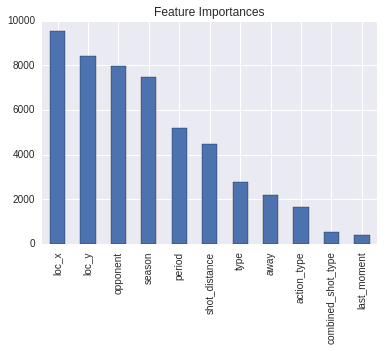

In [130]:
# fit, predict and generate submission file
clf = xgb.XGBClassifier()
clf.set_params(**params)
clf.fit(X_train, y_train)
test.shot_made_flag = [i[1] for i in clf.predict_proba(X_test)]
test[['shot_id', 'shot_made_flag']].to_csv('sub1.csv', index=False)

# display feature importances
# TODO: prettify this code
feature_importances = clf.booster().get_fscore()
to_pop = []
for dummie in binarize:
    feature_importances[dummie] = 0
for feature in feature_importances:
    for dummie in binarize:
        if feature.startswith(dummie) and feature not in binarize:
            feature_importances[dummie] += feature_importances[feature]
            to_pop.append(feature)
for feature in to_pop:
    feature_importances.pop(feature, None)
#for dummie in binarize:
#    feature_importances[dummie] /= dummie_counter[dummie]
feat_imp = pd.Series(feature_importances).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

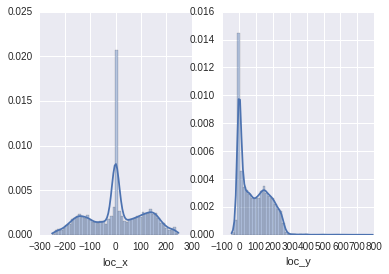

In [138]:
f, (ax1, ax2) = plt.subplots(1,2)
sns.distplot(data.loc_x, ax=ax1)
sns.distplot(data.loc_y, ax=ax2)